# **Project :** Evaluating Solutions to Ameliorate the Impact of Food Deserts in Brooklyn Using AI

## **Problem Statement :** Develop a Deep Learning model to classify food desert and non-food desert areas in Brooklyn (Kings County, New York)

## **1. Import Libraries**

In [1]:
#=================================================================
# For data manipulation, plotting, and miscellaneous
#=================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import calendar
from datetime import datetime

import pickle 
#===============================================================================================
# Import Keras models, layers, activation functions
#===============================================================================================
import tensorflow as tf
tf.random.set_seed(3)
import keras
from keras import models
from keras.models import Sequential
from keras.layers import Dense, ReLU, LeakyReLU, Dropout
from keras import regularizers
from keras import optimizers
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping
from tensorflow.math import confusion_matrix

#=================================================================
# From sklearn import required classes
#=================================================================
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz 
from IPython.display import display, Image
from graphviz import Source
from sklearn import tree

## **2. Load the Dataset and Perform Visualization**

### **2.1. Load the Dataset**

**Data Source :** https://github.com/omdena-chapter-brooklyn-food-desert/Data-Collection-and-Analysis/tree/main

In [2]:
#!git clone https://github.com/omdena-chapter-brooklyn-food-desert/Data-Collection-and-Analysis.git

In [3]:
df_preprocess = pd.read_csv('KingCounty_FoodDeserts_Iteration2_noclasses_2.csv')
df_preprocess.head(3)

,Unnamed: 0,STATEFP_x,COUNTYFP_x,TRACTCE,CensusTract,State,County,Urban,Pop2010,OHU2010,...,COUNTYFP_y,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,SNAP,TargetLabel
0,0,36,47,57800,36047057800,New York,Kings County,1,3176,1077,...,47.0,1400000US36047057800,3.604706e+10,578.0,CT,172233.0,0.0,POLYGON ((-73.95397799999999 40.60140099999999...,0.276615,1
1,1,36,47,37000,36047037000,New York,Kings County,1,4085,1566,...,47.0,1400000US36047037000,3.604704e+10,370.0,CT,336242.0,0.0,"POLYGON ((-73.96615 40.586669, -73.96564099999...",0.178423,0
2,2,36,47,19900,36047019900,New York,Kings County,1,2929,1476,...,47.0,1400000US36047019900,3.604702e+10,199.0,CT,188914.0,0.0,"POLYGON ((-73.96949 40.686288, -73.96749299999...",0.049125,0


In [4]:
df_preprocess.shape

(698, 330)

In [5]:
df_preprocess.columns

Index(['Unnamed: 0', 'STATEFP_x', 'COUNTYFP_x', 'TRACTCE', 'CensusTract',
       'State', 'County', 'Urban', 'Pop2010', 'OHU2010',
       ...
       'COUNTYFP_y', 'AFFGEOID', 'GEOID', 'NAME', 'LSAD', 'ALAND', 'AWATER',
       'geometry', 'SNAP', 'TargetLabel'],
      dtype='object', length=330)

In [6]:
features_req = ['DISADVANTAGE16_20', 'MEDFAMINC16_20', 'SNAP', 'PovertyRate','TractSNAP','TargetLabel']

### **2.2. Store Required Features in DF**

In [7]:
# copy required features
df = df_preprocess.loc[:, features_req]
df.head(3)

,DISADVANTAGE16_20,MEDFAMINC16_20,SNAP,PovertyRate,TractSNAP,TargetLabel
0,0.253815,87500,0.276615,21.6,278,1
1,0.214406,87813,0.178423,15.6,178,0
2,0.079001,161250,0.049125,12.4,183,0


In [8]:
df.rename(columns= {'DISADVANTAGE16_20':'Disadvantage', 'MEDFAMINC16_20':'Medfamilyincome'}, inplace=True)

In [9]:
df.head(3)

,Disadvantage,Medfamilyincome,SNAP,PovertyRate,TractSNAP,TargetLabel
0,0.253815,87500,0.276615,21.6,278,1
1,0.214406,87813,0.178423,15.6,178,0
2,0.079001,161250,0.049125,12.4,183,0


In [10]:
df.shape

(698, 6)

In [11]:
n_labels=df['TargetLabel'].nunique()
n_labels

2

## **3. Exploratory Data Aanalysis (EDA)**

**Features Description:**

* Disadvantage = mean of pfaminclt40k16_20, ppov16_20, and ppubas16_20
    * pfaminclt40k16_20 : Proportion of families with income less than $40,000
    * ppov16_20 : Proportion people w/ income in the past 12 months below poverty level
    * ppubas16_20 : Proportion of households with public assistance income or food stamps
     

* Medfamilyincome = Tract median family income
* SNAP = Proportion of households with public assistance income or food stamps
* PovertyRate = Poverty Rate'
* TractSNAP = Total count of housing units receiving SNAP benefits in tract
   

In [12]:
df.isna().sum()

Disadvantage       0
Medfamilyincome    0
SNAP               0
PovertyRate        0
TractSNAP          0
TargetLabel        0
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698 entries, 0 to 697
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Disadvantage     698 non-null    float64
 1   Medfamilyincome  698 non-null    int64  
 2   SNAP             698 non-null    float64
 3   PovertyRate      698 non-null    float64
 4   TractSNAP        698 non-null    int64  
 5   TargetLabel      698 non-null    int64  
dtypes: float64(3), int64(3)
memory usage: 32.8 KB


### **3.1. Univariate Analysis**

<AxesSubplot: ylabel='TargetLabel'>

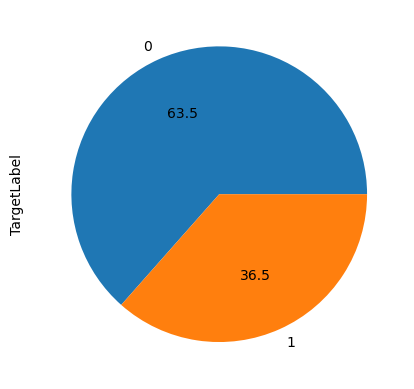

In [14]:
# Percentage of each target label 
df['TargetLabel'].value_counts().plot(kind='pie',autopct='%.1f')

<AxesSubplot: xlabel='TargetLabel', ylabel='count'>

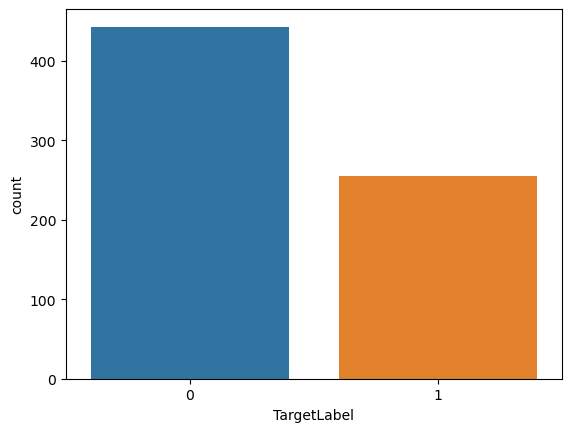

In [15]:
# Count plot
sns.countplot(data=df, x='TargetLabel')

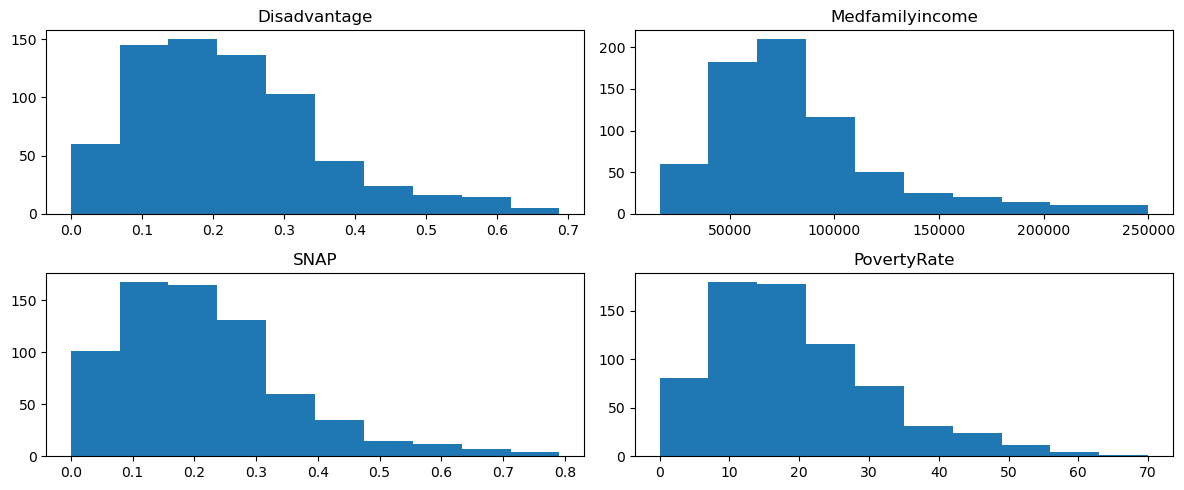

In [16]:
fig = plt.figure(figsize = (12,5))

ax1 = fig.add_subplot(2,2,1)
ax1.hist(df['Disadvantage'])
ax1.set_title('Disadvantage')

ax2 = fig.add_subplot(2,2,2)
ax2.hist(df['Medfamilyincome'])
ax2.set_title('Medfamilyincome')

ax3 = fig.add_subplot(2,2,3)
ax3.hist(df['SNAP'])
ax3.set_title('SNAP')

ax4 = fig.add_subplot(2,2,4)
ax4.hist(df['PovertyRate'])
ax4.set_title('PovertyRate')

plt.tight_layout()
plt.show()

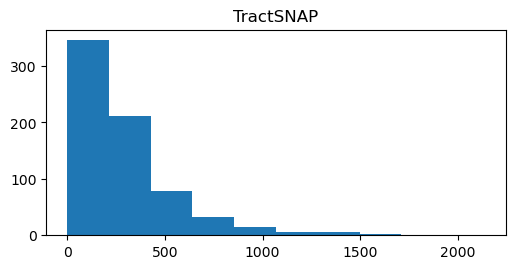

In [17]:
fig = plt.figure(figsize = (10,5))

ax1 = fig.add_subplot(2,2,1)
ax1.hist(df['TractSNAP'])
ax1.set_title('TractSNAP')

plt.tight_layout()
plt.show()

<AxesSubplot: >

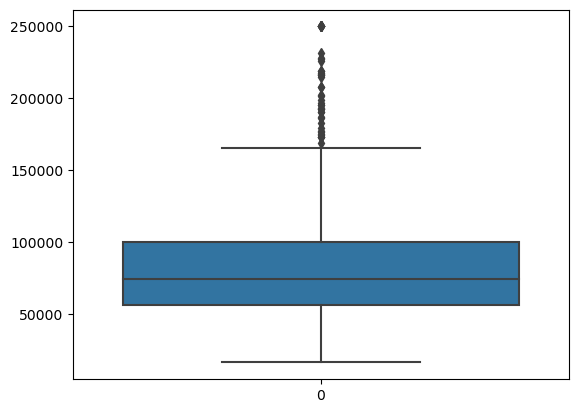

In [18]:
sns.boxplot(df['Medfamilyincome'])

### **3.2. Bivariate Analysis**

#### **3.2.1. Correlation matrix**

In [19]:
# create cocorrelation matrix
corr_df = df.corr().abs()
#corr_df = df.corr()
#mask = np.triu(np.ones_like(corr_df, dtype=bool))
#tri_df = corr_df.mask(mask)
#tri_df
corr_df

,Disadvantage,Medfamilyincome,SNAP,PovertyRate,TractSNAP,TargetLabel
Disadvantage,1.000000,0.757223,0.921736,0.870719,0.753653,0.781236
Medfamilyincome,0.757223,1.000000,0.677852,0.644375,0.537121,0.566810
SNAP,0.921736,0.677852,1.000000,0.776685,0.788666,0.724184
PovertyRate,0.870719,0.644375,0.776685,1.000000,0.665862,0.751412
TractSNAP,0.753653,0.537121,0.788666,0.665862,1.000000,0.569041
TargetLabel,0.781236,0.566810,0.724184,0.751412,0.569041,1.000000


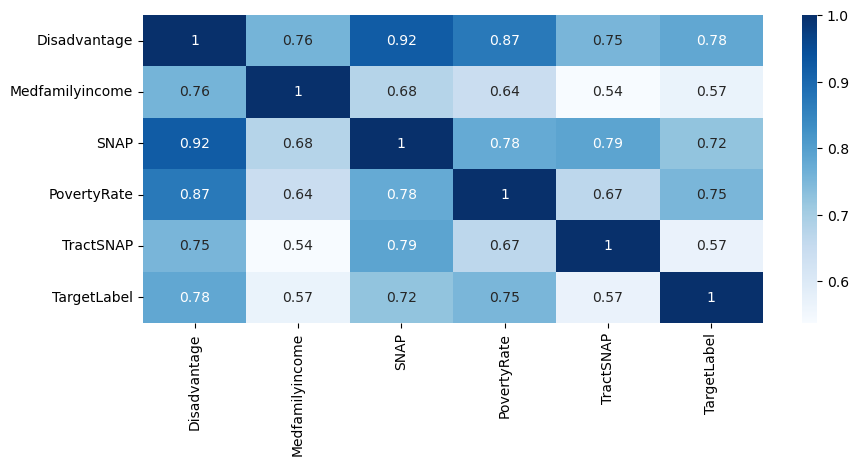

In [20]:
plt.figure(figsize=(10,4))
sns.heatmap(corr_df, annot=True, cmap='Blues')
plt.show()

**Observations:**

**1) 'Disadvantage' feature is having high Correlation (0.92) with 'SNAP' feature, moreover it is dependent on 3 other variables as per NaNDA dataset hence it is dropped.**

In [21]:
df = df.drop(columns=['Disadvantage'])
df.shape

(698, 5)

In [22]:
df.head(3)

,Medfamilyincome,SNAP,PovertyRate,TractSNAP,TargetLabel
0,87500,0.276615,21.6,278,1
1,87813,0.178423,15.6,178,0
2,161250,0.049125,12.4,183,0


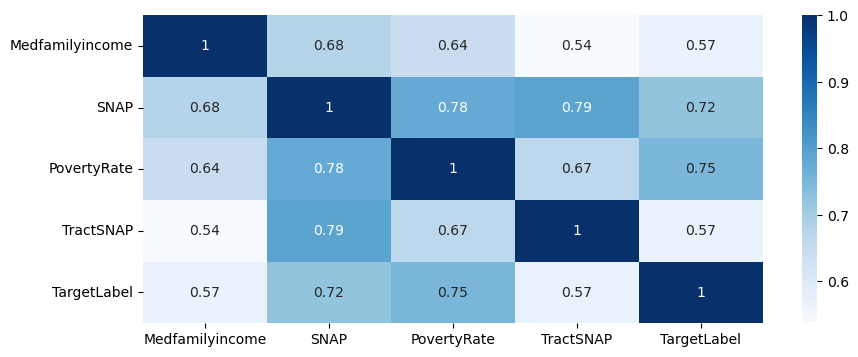

In [23]:
corr_df = df.corr().abs()
plt.figure(figsize=(10,4))
sns.heatmap(corr_df, annot=True, cmap='Blues')
plt.show()

#### **3.2.2. Pair Plots**

<Figure size 800x400 with 0 Axes>

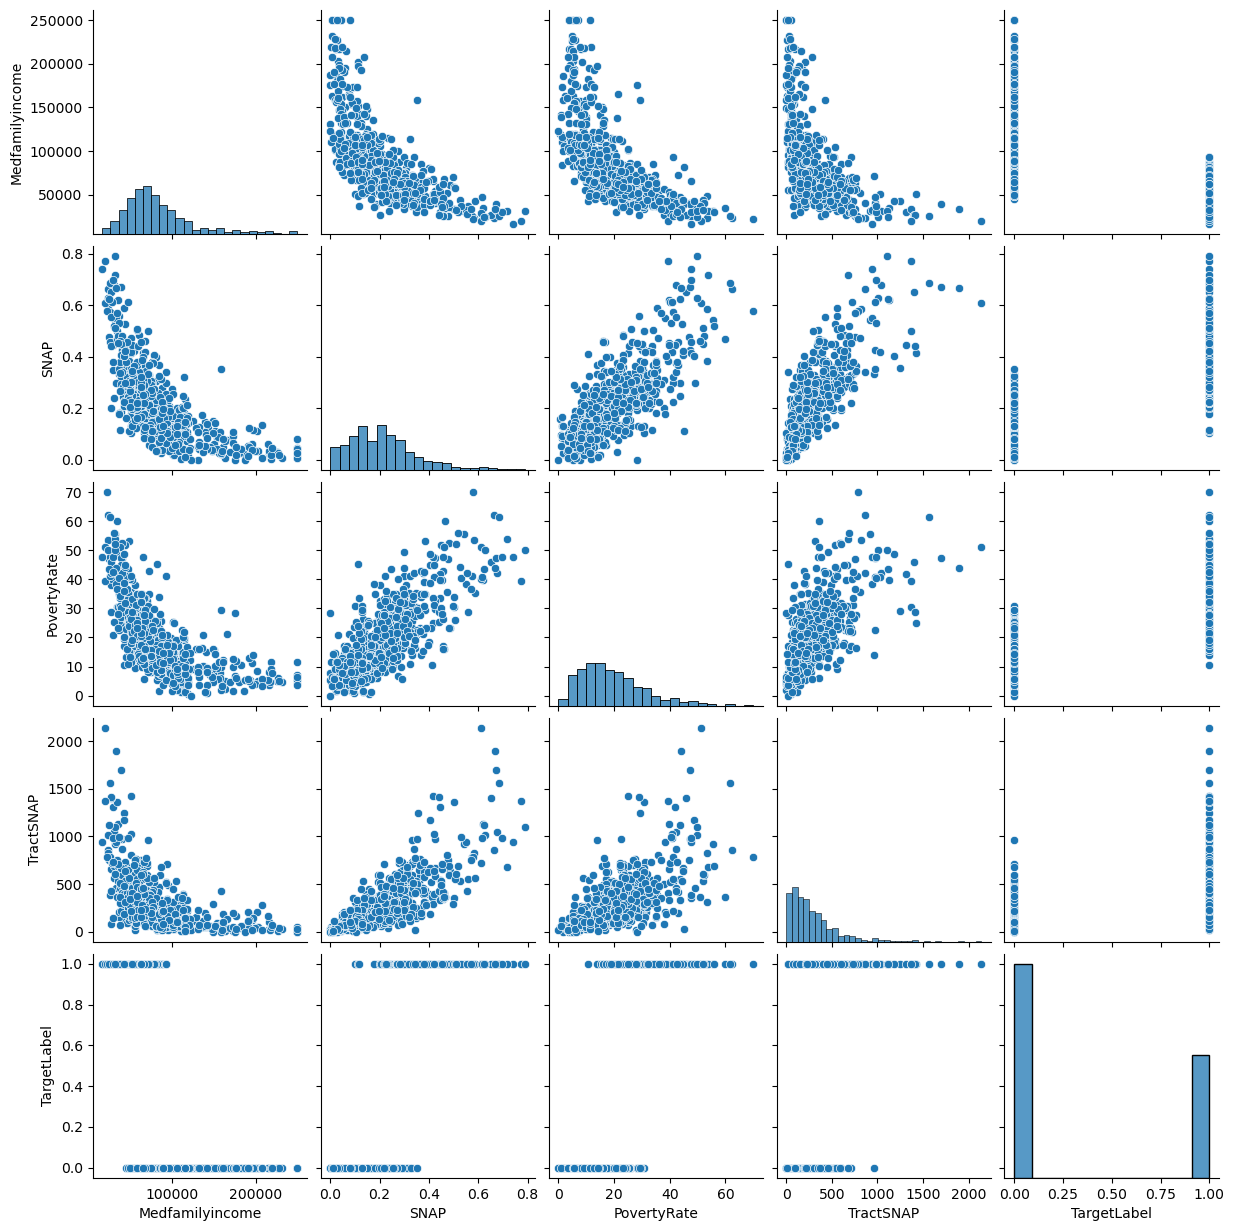

In [24]:
plt.figure(figsize=(8,4))
sns.pairplot(df)

In [25]:
df.to_csv('df.csv')  # saving for reference

### **3.3. Split the data into features (X) and target (y)**

In [26]:
X = df.drop(['TargetLabel'], axis=1)
y = df['TargetLabel']

In [27]:
X.head(3)

,Medfamilyincome,SNAP,PovertyRate,TractSNAP
0,87500,0.276615,21.6,278
1,87813,0.178423,15.6,178
2,161250,0.049125,12.4,183


In [28]:
y.head()

0    1
1    0
2    0
3    0
4    1
Name: TargetLabel, dtype: int64

In [29]:
y.value_counts()

0    443
1    255
Name: TargetLabel, dtype: int64

In [30]:
X = X.to_numpy()

In [31]:
y = y.to_numpy()

#### **3.3.1 Train Test split**

In [32]:
# Split the data into training and test sets
# parameter 'stratify' ensures the training and test subsets that have the same proportions of class

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 3, stratify = y )

In [33]:
type(y_train)

numpy.ndarray

In [34]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((628, 4), (70, 4), (628,), (70,))

In [35]:
X.shape, y.shape

((698, 4), (698,))

In [36]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [37]:
# Unique values in the y_train 
print(np.unique(y_train))

# Unique values in the y_test 
print(np.unique(y_test))

[0 1]
[0 1]


In [38]:
train_data = np.hstack((X_train,y_train))
test_data = np.hstack((X_test,y_test))

In [39]:
np.savetxt("train_data.csv", train_data, delimiter=",")
np.savetxt("test_data.csv", test_data, delimiter=",")

### **3.4. Standardize the data**

**Since we don't know the lower and upper bounds for each feature in the dataset, hence we are using Standardscaler instead of MinMaxScaler**


In [40]:
X_scaler = StandardScaler()
#--------------------------------------------------
# Transform train and test data sets
#--------------------------------------------------
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)


In [41]:
X_train[0]

array([ 0.08719288, -0.27324164, -0.33310534, -0.40862492])

In [42]:
X_test[0]

array([-0.5945144 ,  0.34200377,  0.61760602,  0.68417295])

In [43]:
y_train[:5]

array([[0],
       [0],
       [0],
       [0],
       [1]], dtype=int64)

In [44]:
y_test[:5]

array([[1],
       [0],
       [1],
       [0],
       [0]], dtype=int64)

## **4. Artificial Neural Network (ANN) Model**

### **4.1. Create the Model**

In [45]:
X_train.shape[1]

4

In [46]:
model = Sequential(name='Sequential')

input_shape1 = (X_train.shape[1],)   # number of x_train columns

model.add(Dense(64, activation='relu', input_shape =input_shape1, name='Hidden_1'))
model.add(Dense(64, activation='relu', input_shape =input_shape1, name='Hidden_2'))
model.add(Dense(2, activation='softmax', name ='Outputlayer'))  # softmax is for multi-class classification, we have 5 classes [0-4]

model.summary()

Model: "Sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_1 (Dense)            (None, 64)                320       
                                                                 
 Hidden_2 (Dense)            (None, 64)                4160      
                                                                 
 Outputlayer (Dense)         (None, 2)                 130       
                                                                 
Total params: 4,610
Trainable params: 4,610
Non-trainable params: 0
_________________________________________________________________


### **4.2. Compile the model**

**As our labels (y_train, y_test) are numbers like 0,1,2,3,.. which are not one-hot encoded, so we need to use sparse_categoritcal_crossentropy as loss function.**

In [47]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#sgd = SGD(learning_rate=0.001, momentum=0.9)
#model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### **4.3. Train the Model**

In [48]:
X_train.shape

(628, 4)

In [49]:
np_epochs = 50
batchsize = 4
val_split = 0.1

earlystop = EarlyStopping(monitor='val_accuracy', patience = 5, min_delta = 0.01, mode = 'max')

training = model.fit(X_train, y_train, validation_split=val_split, batch_size = batchsize, epochs = np_epochs, callbacks=[earlystop])

#training = model.fit(X_train, y_train, validation_split=val_split, epochs = np_epochs)


Epoch 1/50
142/142 [==============================] - 2s 6ms/step - loss: 0.3252 - accuracy: 0.8814 - val_loss: 0.1054 - val_accuracy: 0.9841
Epoch 2/50
142/142 [==============================] - 1s 4ms/step - loss: 0.0960 - accuracy: 0.9699 - val_loss: 0.0523 - val_accuracy: 0.9841
Epoch 3/50
142/142 [==============================] - 1s 4ms/step - loss: 0.0674 - accuracy: 0.9788 - val_loss: 0.0389 - val_accuracy: 0.9841
Epoch 4/50
142/142 [==============================] - 1s 4ms/step - loss: 0.0595 - accuracy: 0.9770 - val_loss: 0.0366 - val_accuracy: 0.9841
Epoch 5/50
142/142 [==============================] - 1s 4ms/step - loss: 0.0563 - accuracy: 0.9823 - val_loss: 0.0301 - val_accuracy: 1.0000
Epoch 6/50
142/142 [==============================] - 1s 4ms/step - loss: 0.0514 - accuracy: 0.9823 - val_loss: 0.0294 - val_accuracy: 1.0000
Epoch 7/50
142/142 [==============================] - 1s 4ms/step - loss: 0.0508 - accuracy: 0.9770 - val_loss: 0.0265 - val_accuracy: 1.0000
Epoch 

### **4.4. Plot the Accuracy and Loss history**

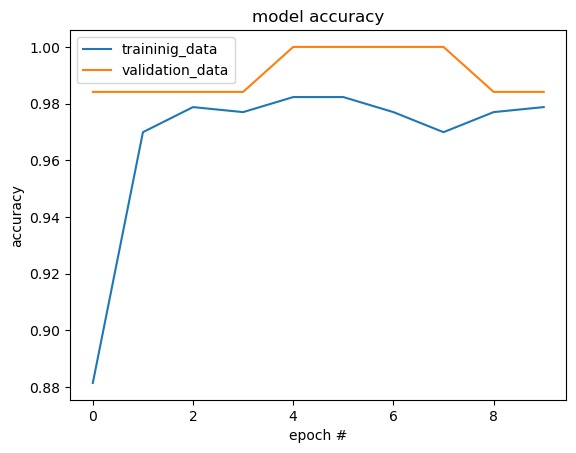

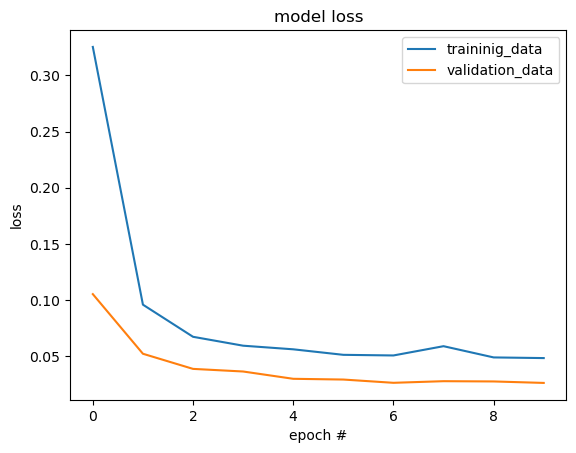

In [50]:
#============================================
# Plot the accuracy and loss curves 
#============================================
plt.plot(training.history['accuracy'], label='traininig_data')
plt.plot(training.history['val_accuracy'], label='validation_data')
plt.legend()
plt.title("model accuracy")
plt.xlabel("epoch #")
plt.ylabel("accuracy")
plt.show()

plt.plot(training.history['loss'], label='traininig_data')
plt.plot(training.history['val_loss'], label='validation_data')
plt.legend()
plt.title("model loss")
plt.xlabel("epoch #")
plt.ylabel("loss")
plt.show()

### **4.5. Evaluate the Model on Test Dataset**

In [51]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 3ms/step - loss: 0.0647 - accuracy: 0.9571


In [52]:
print("Test accuracy : ", test_accuracy)

Test accuracy :  0.9571428298950195


In [53]:
print(X_test.shape)

(70, 4)


### **4.6. Confusion Matrix**

In [54]:
y_pred = model.predict(X_test)    #model.predict() gives the probability of each class for each data point

3/3 [==============================] - 0s 3ms/step


In [55]:
y_pred.shape

(70, 2)

In [56]:
y_pred[0]

array([0.00224415, 0.9977558 ], dtype=float32)

In [57]:
np.argmax(y_pred[0])  # index value of the maximum probability value which is nothing but class value

1

In [58]:
#converting the prediction probabilities to class label for all test data point

y_pred_labels = [np.argmax(x) for x in y_pred]  # List comprehension
type(y_pred_labels)

list

In [59]:
y_pred_labels[0]

1

In [60]:
y_test[2]

array([1], dtype=int64)

In [61]:
confusion_mat = confusion_matrix(y_test, y_pred_labels)
confusion_mat

array([[43,  1],
       [ 2, 24]], dtype=int64)

In [62]:
pd.DataFrame(confusion_mat,columns=list(range(0,n_labels)))

,0,1
0,43,1
1,2,24


Text(0.5, 14.722222222222216, 'Predicted Labels')

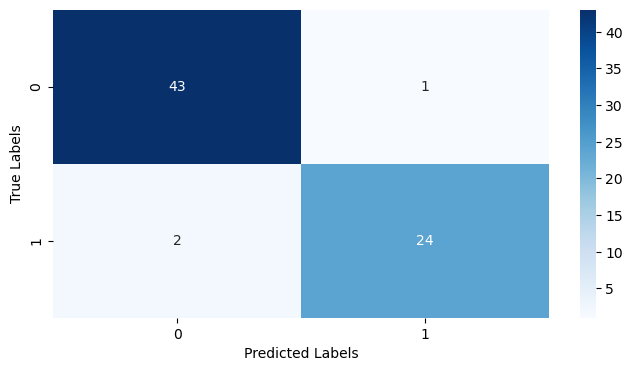

In [63]:
plt.figure(figsize=(8,4))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')

### **4.6. Classification Report**

In [64]:
# Print a Classification Report and the accuracy score (classification accuracy)
#===================================================================================================
from sklearn.metrics import confusion_matrix , classification_report
y_pred = model.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]     # get the maximum probability class number (here it is same as index value)

print("-"*80)
print("Classification Report: \n", classification_report(y_test, y_pred_classes))

print("-"*80)
print("Classification accuracy on Test Dataset: %0.6f" % metrics.accuracy_score(y_test, y_pred_classes))
print("-"*80)

3/3 [==============================] - 0s 3ms/step
--------------------------------------------------------------------------------
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97        44
           1       0.96      0.92      0.94        26

    accuracy                           0.96        70
   macro avg       0.96      0.95      0.95        70
weighted avg       0.96      0.96      0.96        70

--------------------------------------------------------------------------------
Classification accuracy on Test Dataset: 0.957143
--------------------------------------------------------------------------------


## **5. Save the Trained model**

In [65]:
# Save the trained ML model 
model.save("FoodDesert_Classification_Iteration2_DL_Model_1.h5")

## **6. Prediction**

In [66]:
X_train[:3]

array([[ 0.08719288, -0.27324164, -0.33310534, -0.40862492],
       [-0.08205715, -0.84672836, -0.8463212 , -0.84421568],
       [ 2.38465533, -1.52230996, -1.19968295, -1.08875786]])

In [67]:
df1 = pd.DataFrame(X_train)
df1.head()

,0,1,2,3
0,0.087193,-0.273242,-0.333105,-0.408625
1,-0.082057,-0.846728,-0.846321,-0.844216
2,2.384655,-1.522310,-1.199683,-1.088758
3,0.070349,-0.155949,-0.400412,-0.592032
4,-0.946836,0.076383,-0.013397,-0.557643


### **6.1 For Sample from Test Dataset**

In [68]:
X_test.shape

(70, 4)

In [69]:
# predicting for random sample from train or test data (this is temporary, and will be removed before deploying the model)
sample_no = 60

predict_sample  = X_test[sample_no]
predict_sample

array([-1.08528181,  2.37504306,  0.78587352,  1.03188136])

In [70]:
input_data = predict_sample

# changing the input_data to numpy array
#input_data = np.asarray(input_data)

# reshape the array as we are predicting for one instance
input_data = input_data.reshape(1,-1)
predict_label = np.argmax(model.predict(input_data))   # prediction

print('-'*50)
print("Predicted Label : ", predict_label)
print("Actual Label    : ", y_test[sample_no][0])

print('-'*50)
if (predict_label == 0):
  print('Not a Food Desert')
else :
  print('Food Desert')

print('-'*50)

1/1 [==============================] - 0s 23ms/step
--------------------------------------------------
Predicted Label :  1
Actual Label    :  1
--------------------------------------------------
Food Desert
--------------------------------------------------


## **Observations**

**For this dataset**, by comparing the model accuracy on testing dataset, it has been observed that there is no major difference between DL and ML models.

* K-Means Clustering (**yet to finalize the appropriate clustering algorithm for this dataset**):
     * Training data has been standardized with StandardScaler
     * One food desert and one non-food desert data point are used as initial cluster seeds.
     * Algorithm has labelled the high poverty rate census tracts in to one class, and the remaining in to other class.
     * Labels obtained from clustering are : **0- not a food desert, 1-food desert**